# Access cloud data examples tutorial

- Funding: Interagency Implementation and Advanced Concepts Team [IMPACT](https://earthdata.nasa.gov/esds/impact) for the Earth Science Data Systems (ESDS) program and AWS Public Dataset Program
  
### Credits: Tutorial development
* [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute

### Data proximate computing
These are BIG datasets that you can analyze on the cloud without downloading the data.  
You can run this on your phone, a Raspberry Pi, laptop, or desktop.   
By using public cloud data, your science is reproducible and easily shared!

### Here we will demonstrate some ways to access the different SST datasets on AWS:
- AWS MUR sea surface temperatures
- AWS GOES sea surface temperatures
- AWS Himawari sea surface temperatures
- ERA5 data 

### To run this notebook

Code is in the cells that have <span style="color: blue;">In [  ]:</span> to the left of the cell and have a colored background

To run the code:
- option 1) click anywhere in the cell, then hold `shift` down and press `Enter`
- option 2) click on the Run button at the top of the page in the dashboard

Remember:
- to insert a new cell below press `Esc` then `b`
- to delete a cell press `Esc` then `dd`

### First start by importing libraries


In [1]:
# filter some warning messages
import warnings 
warnings.filterwarnings("ignore") 

#libraries
import datetime as dt
import xarray as xr
import fsspec
import s3fs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# make datasets display nicely
xr.set_options(display_style="html")  

#magic fncts #put static images of your plot embedded in the notebook
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 


## [MUR SST](https://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST) [AWS Public dataset program](https://registry.opendata.aws/mur/) 

### Access the MUR SST Zarr store which is in an s3 bucket.  

![image](https://podaac.jpl.nasa.gov/Podaac/thumbnails/MUR-JPL-L4-GLOB-v4.1.jpg)

We will start with my favorite Analysis Ready Data (ARD) format: [Zarr](https://zarr.readthedocs.io/en/stable/).  Using data stored in Zarr is fast, simple, and contains all the metadata normally in a netcdf file, so you can figure out easily what is in the datastore.  

- Fast - Zarr is fast because all the metadata is consolidated into a .json file.  Reading in massive datasets is lightning fast because it only reads the metadata and does read in data until it needs it for compute.

- Simple - Filenames?  Who needs them? Who cares?  Not I.  Simply point your read routine to the data directory.

- Metadata - all you want!

[fsspec.get_mapper](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=get_mapper#fsspec.get_mapper) Reads a url

[xr.open_zarr](http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html) Reads a Zarr store into an Xarray dataset


In [ ]:
%%time
file_location = 's3://mur-sst/zarr'

ikey = fsspec.get_mapper(file_location, anon=True)

ds_sst = xr.open_zarr(ikey,consolidated=True)

ds_sst

### Read entire 10 years of data at 1 point.

Select the ``analysed_sst`` variable over a specific time period, `lat`, and `lon` and load the data into memory.  This is small enough to load into memory which will make calculating climatologies easier in the next step.

In [ ]:
%%time

sst_timeseries = ds_sst['analysed_sst'].sel(time = slice('2010-01-01','2020-01-01'),
                                            lat  = 47,
                                            lon  = -145
                                           ).load()

sst_timeseries.plot()

### The anomaly is more interesting...  

Use [.groupby](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html#xarray-dataarray-groupby) method to calculate the climatology and [.resample](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html#xarray-dataset-resample) method to then average it into 1-month bins.
- [DataArray.mean](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray-dataarray-mean) arguments are important! Xarray uses metadata to plot, so keep_attrs is a nice feature.  Also, for SST there are regions with changing sea ice.  Setting skipna = False removes these regions. 

In [ ]:
%%time

sst_climatology = sst_timeseries.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

sst_anomaly = sst_timeseries.groupby('time.dayofyear')-sst_climatology

sst_anomaly_monthly = sst_anomaly.resample(time='1MS').mean(keep_attrs=True,skipna=False)

#plot the data
sst_anomaly.plot()
sst_anomaly_monthly.plot()
plt.axhline(linewidth=2,color='k')

# Read AWS GOES SSTs

![](./aws.png)

## Zarr made it seem so easy to read and access cloud SST data! 
## It is always that easy, right?

- When data is just dumped on the cloud, it is still useful, but can be challenging to use.  
Which brings us to GOES SSTs.....

- Info on the data is here -- GOES has a lot of different parameters and they are all stored in different files with names that are difficult to understand.  There are *80* different data products.  This link lists them all and explains the different directory names. [AWS info on GOES SST data](https://docs.opendata.aws/noaa-goes16/cics-readme.html).  

- The GOES data is netCDF format.  There is a different for each of the 80 projects for year/day/hour.  A lot of files.  I find it really useful to 'browse' s3: buckets so that I can understand the directory and data structure.  [Explore S3 structure](https://noaa-goes16.s3.amazonaws.com/index.html).  The directory structure is `<Product>/<Year>/<Day of Year>/<Hour>/<Filename>`

- In the code below we are going to create a function that searches for all files from a certain day, then creates the keys to opening them.  The files are so messy that opening a day takes a little while.  There are other ways you could write this function depending on what your analysis goals are, this is just one way to get some data in a reasonable amount of time. 
- This function uses 
- [`s3fs.S3FileSystem`](https://s3fs.readthedocs.io/en/latest/) which holds a connection with a s3 bucket and allows you to list files, etc.  
- [`xr.open_mfdataset`](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset) opens a list of filenames and concatenates the data along the specified dimensions  

Website [https://registry.opendata.aws/noaa-goes/](https://registry.opendata.aws/noaa-goes/)



In [2]:
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'})
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds


## Open a day of GOES-16  (East Coast) Data

In [ ]:
%%time
#lyr, idyjl = 2020, 150  #may 30, 2020
lyr, idyjl = 2020, 210  #may 30, 2020

ds = get_geo_data('goes-east',lyr,idyjl)

ds.to_zarr('./goes.zarr')

ds = xr.open_zarr('./goes.zarr')

ds

In [ ]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.isel(time=14).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

In [ ]:
%%time

mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True

mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

## Read AWS JMA Himawari SSTs
- define a function to get all the filenames for a day
- AWS info on Himawari SST data, [here](https://www.goes.noaa.gov/f_himawari-8.html)
- Explore S3 structure [here](https://noaa-himawari8.s3.amazonaws.com/index.html)
- SSTs are given in L2P and L3C GHRSST data formats.  
L2P has dims that not mapped to a regular grid.  
L3C is mapped to a grid, with dims lat,lon.

Website [https://registry.opendata.aws/noaa-himawari/](https://registry.opendata.aws/noaa-himawari/)


In [3]:
%%time
lyr, idyjl = 2020, 205

ds = get_geo_data('himawari',lyr,idyjl)

for var in ds:
    if (var=='sea_surface_temperature') or (var=='quality_level'):
        continue
    ds = ds.drop({var})

ds.to_zarr('./himawari.zarr')


CPU times: user 41.4 s, sys: 17.4 s, total: 58.8 s
Wall time: 5min 29s


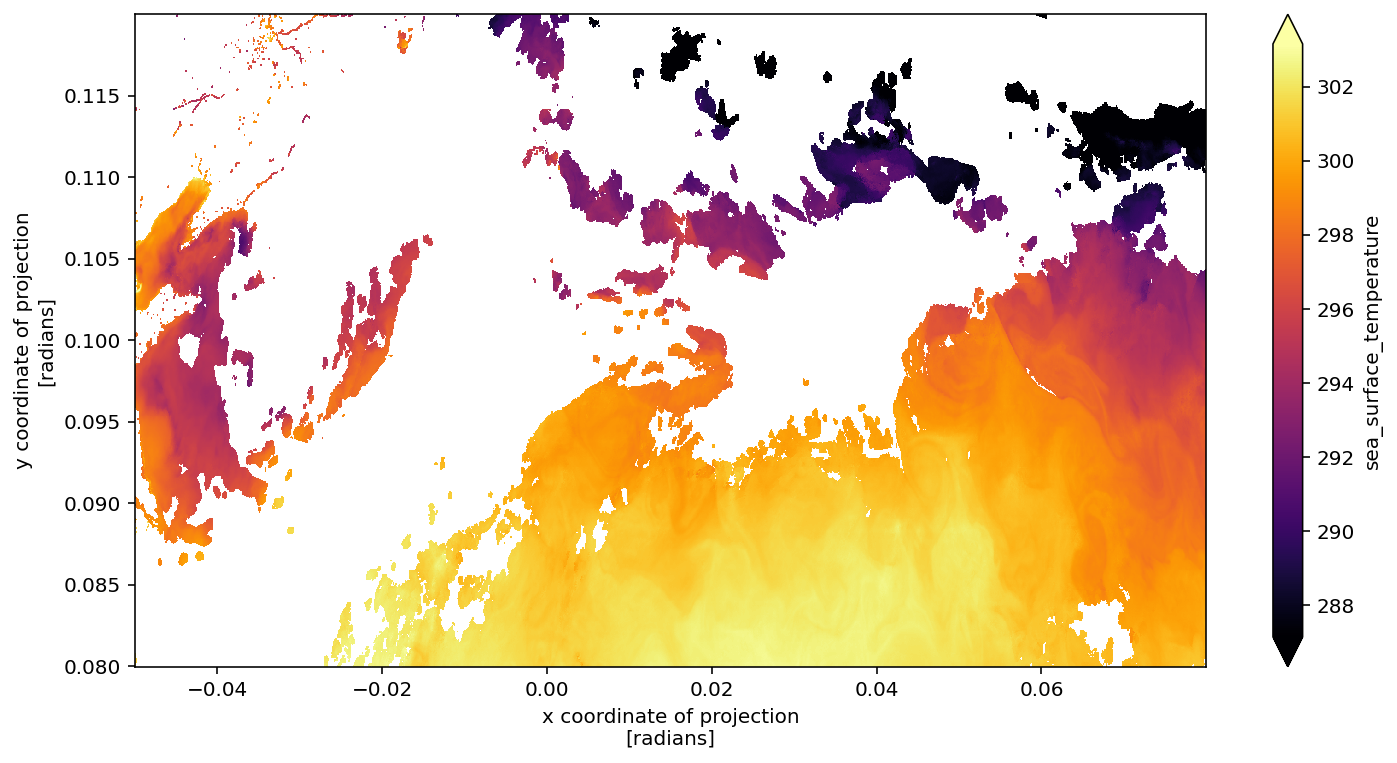

In [4]:

ds = xr.open_zarr('./himawari.zarr')

subset = ds.sel(x=slice(-0.05,0.08),y=slice(0.12,0.08))

masked = subset.sea_surface_temperature.where(subset.quality_level>=4)

mean_dy = masked.mean('time',skipna=True)   #here I want all possible values so skipna=True

mean_dy.plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

## ERA5 Data Structure on S3

The ERA5 data is organized into NetCDF files per variable, each containing a month of hourly data. 
The directory structure is `/{year}/{month}/main.nc` for all the variables or `/{year}/{month}/data/{var}.nc` for just a single variable.

Variables:
- snow_density
- sea_surface_temperature
- lwe_thickness_of_surface_snow_amount
- eastward_wind_at_10_metres
- northward_wind_at_10_metres
- time1_bounds
- air_temperature_at_2_metres_1hour_Maximum
- air_temperature_at_2_metres_1hour_Minimum
- precipitation_amount_1hour_Accumulation
- eastward_wind_at_100_metres
- air_temperature_at_2_metres
- dew_point_temperature_at_2_metres
- integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation
- northward_wind_at_100_metres
- air_pressure_at_mean_sea_level
- surface_air_pressure

For example, the full file path for sea surface temperature for January 2008 is:

/2008/01/data/sea_surface_temperature.nc

- Note that due to the nature of the ERA5 forecast timing, which is run twice daily at 06:00 and 18:00 UTC, the monthly data file begins with data from 07:00 on the first of the month and continues through 06:00 of the following month. We'll see this in the coordinate values of a data file we download later in the notebook.

- Granule variable structure and metadata attributes are stored in main.nc. This file contains coordinate and auxiliary variable data. This file is also annotated using NetCDF CF metadata conventions.


In [ ]:
def get_era5(var,lyr):
    syr=str(lyr).zfill(4)
    fs = s3fs.S3FileSystem(anon=True)
    if var=='all':
        file_location = fs.glob('s3://era5-pds/'+syr+'/*/*.nc')
    else:
        file_location = fs.glob('s3://era5-pds/'+syr+'/*/data/'+var+'*.nc')
    file_ob = [fs.open(file) for file in file_location]        
    ds=xr.open_mfdataset(file_ob,combine='nested',concat_dim='time0') 
    #ds['sea_surface_temperature']-=273.15
    #ds['sea_surface_temperature'].attrs['units'] = '$^\circ$C'
    return ds

In [ ]:
lyr=2019
ds = get_era5('all',lyr)
ds.to_zarr('./era5.zarr')
ds = xr.open_zarr('./era5.zarr')

In [ ]:
ds['wspd']=np.sqrt(ds.eastward_wind_at_10_metres**2+ds.northward_wind_at_10_metres**2)

In [ ]:
dy = ds.resample(time0='1D').mean(keep_attrs=True,skipna=False)
dy

In [ ]:
dy.sea_surface_temperature[0,:,:].plot()

In [ ]:
dy.sea_surface_temperature.sel(lon=200,lat=8).plot()

In [ ]:
#ds_cov = xr.cov(dy.sea_surface_temperature,dy.wspd,dim='time0')